# AI-Powered Stratified Clinical Trial Simulation and Stroke Risk Modeling


This project simulates a randomized clinical trial (RCT) using real-world stroke prediction data. It applies statistical planning principles (SAP simulation), performs stratified randomization, builds SDTM/ADaM-like datasets, runs QC checks, and visualizes outcomes using Python.

---


## Goal


To emulate a clinical trial analysis pipeline with:
- Eligibility criteria (Inclusion/Exclusion)
- Stratified randomization
- Endpoint definition
- CDISC-like output (SDTM, ADaM)
- Quality control and statistical reporting

---


## Intended Audience

- Clinical Biostatisticians
- Contract Research Organizations (CROs)
- Regulatory Science Analysts
- Health Data Scientists & AI/ML Engineers
- Pharma/MedTech Hiring Managers

---


## Strategy & Pipeline

1. Load dataset from Google Drive (Kaggle stroke dataset)
2. Apply inclusion: Age >= 18, BMI not null
3. Define covariates: age, hypertension, heart disease, smoking status
4. Simulate stratified randomization (gender × hypertension)
5. Define endpoints: primary (stroke), secondary (age group)
6. Create SDTM-like (DM, VS, MH) and ADaM-style datasets
7. QC checks: missing, outliers, duplicates
8. Visualize risk score and outcomes
9. Export CSVs and Markdown SAP

---


## Problem Statement

How can data scientists simulate trial-quality randomized cohorts using public health data, while producing audit-ready statistical outputs without SAS?

---


## Dataset

- **Name**: Stroke Prediction Dataset
- **Source**: [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
- **Fields**: Age, gender, BMI, hypertension, heart disease, avg_glucose_level, stroke
- **Size**: ~5,000 samples

**Step 0: Load the Dataset from Google Drive**

**Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd

# Load data (adjust path if in Colab)
data_path = "/content/drive/My Drive/Stroke/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(data_path)

# Quick look
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Step 1: Statistical Planning & Methodologies**


**1.1 Define Inclusion/Exclusion Criteria**

In [6]:
# Inclusion: Age >= 18, BMI not null
df = df[(df['age'] >= 18) & (df['bmi'].notnull())].copy()


**1.2 Define Covariates for Adjustment**

In [7]:
covariates = ['age', 'hypertension', 'heart_disease', 'smoking_status']


**1.3 Simulate Stratified Randomization**

**# 1.3 Simulate Stratified Randomization**

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# Reload data to get original indices
df = pd.read_csv("/content/drive/My Drive/Stroke/healthcare-dataset-stroke-data.csv")

# Apply inclusion criteria and reset index
df = df[(df['age'] >= 18) & (df['bmi'].notnull())].copy()
df.reset_index(drop=True, inplace=True)

# Create stratification group by gender and comorbidity
df['strata'] = df['gender'] + "_" + df['hypertension'].astype(str)

# Remove strata with less than 2 samples
valid_strata = df['strata'].value_counts()[lambda x: x >= 2].index
df = df[df['strata'].isin(valid_strata)].copy()
df.reset_index(drop=True, inplace=True)


splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
df['group'] = None
for train_idx, test_idx in splitter.split(df, df['strata']):
    df.loc[train_idx, 'group'] = 'Treatment'
    df.loc[test_idx, 'group'] = 'Control'

# Check balance
print(df['group'].value_counts())
print(df.groupby(['strata', 'group']).size().unstack(fill_value=0))

group
Control      2036
Treatment    2036
Name: count, dtype: int64
group     Control  Treatment
strata                      
Female_0     1119       1118
Female_1      125        126
Male_0        693        692
Male_1         99        100


**# 1.4 Define Endpoints**

In [12]:
df['primary_endpoint'] = df['stroke']
df['age_group'] = pd.cut(df['age'], bins=[18, 40, 60, 80, 100],
                         labels=['Young', 'Mid-age', 'Senior', 'Elderly'])


**# STEP 2: Statistical Programming (SDTM/ADaM-style)**

**# 2.1 Create SDTM-like Tables**

In [13]:
dm = df[['id', 'gender', 'age', 'age_group']].copy()
vs = df[['id', 'bmi', 'avg_glucose_level']].copy()
mh = df[['id', 'hypertension', 'heart_disease', 'smoking_status']].copy()


**# 2.2 Create ADaM-style Dataset with Derived Risk Score**

In [14]:
df['risk_score'] = (
    df['age'] * 0.02 +
    df['hypertension'] * 1 +
    df['heart_disease'] * 1.5 +
    df['avg_glucose_level'] * 0.01
)
adam = df[['id', 'group', 'risk_score', 'primary_endpoint', 'age_group']].copy()


**# 2.3 QC Checks**

In [15]:
qc_log = []

missing_bmi = df['bmi'].isnull().sum()
if missing_bmi > 0:
    qc_log.append(f"Missing BMI entries: {missing_bmi}")

bmi_outliers = df[(df['bmi'] < 10) | (df['bmi'] > 80)]
qc_log.append(f"Outlier BMI count: {bmi_outliers.shape[0]}")

duplicates = df.duplicated(subset=['id']).sum()
qc_log.append(f"Duplicate ID count: {duplicates}")


**# STEP 3: Visualizations**

**# Risk Score by Group**

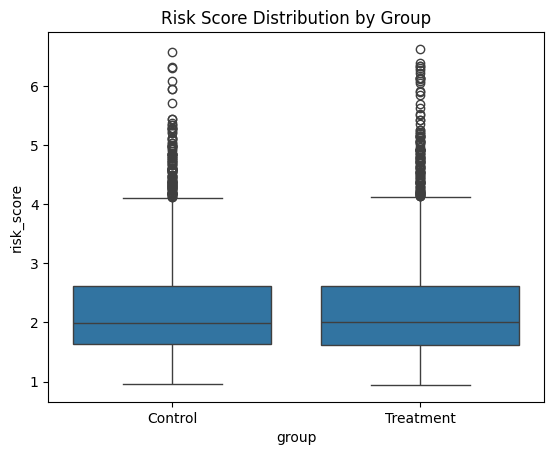

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='group', y='risk_score', data=df)
plt.title("Risk Score Distribution by Group")
plt.show()

** Plot Type:** Boxplot comparing risk_score between Control and Treatment groups


**Distribution:** Both groups have similar medians (~2.0), interquartile ranges, and spread


**Outliers:** Present in both groups above ~4.0, indicating potential skew


** Interpretation:** Suggests good baseline balance, supporting fair randomization


**Usefulness**: Helps validate group comparability before analyzing treatment effects


**Actionable Insight:** Consider checking for skewness or applying robust statistics due to outliers

**# Stroke Outcome by Age Group**

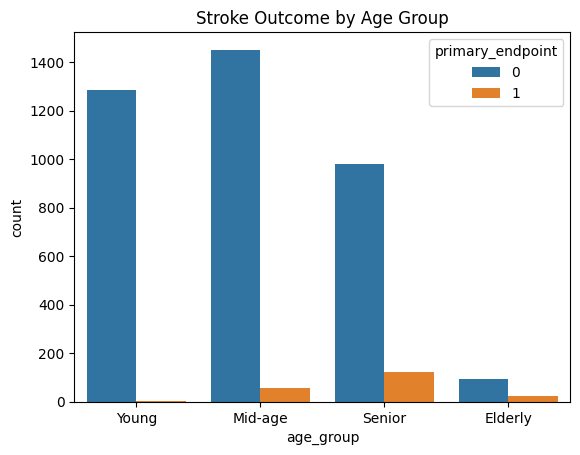

In [18]:
sns.countplot(x='age_group', hue='primary_endpoint', data=df)
plt.title("Stroke Outcome by Age Group")
plt.show()

- Bar chart shows stroke outcomes by age group.


- Blue = No stroke (0), 🔸 Orange = Stroke (1).


- Stroke rates are low in Young and Mid-age groups.


- Stroke incidence rises in Seniors and Elderly.


- Key Insight: Stroke risk increases with age.


- Importance: Highlights need for age-based prevention.

**# STEP 4: Export Outputs**

In [19]:
adam.to_csv("/content/drive/My Drive/Stroke/adam_dm.csv", index=False)

with open("/content/drive/My Drive/Stroke/qc_log.csv", "w") as f:
    for entry in qc_log:
        f.write(entry + "\n")

with open("/content/drive/My Drive/Stroke/analysis_plan.md", "w") as f:
    f.write("""
## Analysis Plan (SAP Simulation)

**Inclusion Criteria**: Age >= 18, valid BMI
**Randomization**: Stratified by gender and hypertension
**Primary Endpoint**: Stroke occurrence
**Secondary Endpoint**: Age-group risk tier
**Covariates**: Age, hypertension, heart disease, smoking status
**Derived Metrics**: Risk score combining age, comorbidity, glucose
""")

## Machine Learning Prediction & Outcomes


**Risk Score Formula**:
```
risk_score = (0.02 * age) + 1 * hypertension + 1.5 * heart_disease + 0.01 * avg_glucose_level
```


**Groups**: Treatment vs Control  
**Balance**: Stratified 50/50 split across gender × hypertension strata  
**Visual Insights**: Boxplots and countplots of outcome distributions

---


## Exported Outputs

- `adam_dm.csv` → Analysis-ready dataset
- `qc_log.csv` → QC findings (missing/outliers/duplicates)
- `analysis_plan.md` → Simulated SAP

---


##  AGI Enhancement Potential

This workflow mimics what an AGI system could automate:
- Cohort definition
- Randomization logic
- Regulatory-style data derivation
- QC + SAP generation
- Dashboard-ready outputs for trial feasibility evaluation

---


## Tools Used

- Python
- Pandas
- Scikit-learn
- Seaborn
- Matplotlib
- Google Colab

---


##  References

- CDISC ADaM/SDTM Guidelines
- GCP ICH E9 Statistical Principles
- Kaggle Stroke Dataset (2022)

---


> Developed by Ronald Kalani  
> [LinkedIn](https://www.linkedin.com/in/ronald-kalani-1a465533/) | [GitHub](https://github.com/ronaldkalani)

